# California Area House Price Prediction 

In [9]:
#import modules and data

import pandas as pd
from sklearn.model_selection import train_test_split



I load the data and view see what columns it has. I remove the Id column

In [10]:
data=pd.read_csv('data/Cali_housing.csv')
print(data.shape)
data.head()


(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Here is some data pre-processing. 207 entries have N/A for total_bedrooms. This is very few compared to the sample size and there doesn't appear to be any connection between N/A entries and the rest of the data, so I conclude dropping these entries will be unlikely to significantly affect the prediction model.

The ocean_proximity field is non-quantitative. There are only 5 unique entries which makes one-hot encoding reasonable. This seemed to perform better than ordinal encoding.

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

print("null data entries: ")
print(data.isnull().sum(),"\n")
drop_na_data=data.dropna(axis=0)



print("cardinality of 'ocean proximity': ", data.ocean_proximity.nunique(),"\n")

#"""
OH_encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols=pd.DataFrame(OH_encoder.fit_transform(pd.DataFrame(drop_na_data['ocean_proximity'])))
OH_cols.index=drop_na_data.index
OH_cols.columns=OH_cols.columns.astype(str)
pre_processed_data=pd.concat([drop_na_data.drop('ocean_proximity',axis=1),OH_cols],axis=1)
#"""


"""
ordinal_encoder = OrdinalEncoder()
pre_processed_data=drop_na_data.copy()
pre_processed_data['ocean_proximity'] = ordinal_encoder.fit_transform(pd.DataFrame(drop_na_data['ocean_proximity']))
"""


print("pre-processed data shape: ", pre_processed_data.shape)



null data entries: 
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64 

cardinality of 'ocean proximity':  5 

pre-processed data shape:  (20433, 14)


In [12]:
pre_processed_data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,0,1,2,3,4
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0


In [13]:
y_full=pre_processed_data.median_house_value
x_full=pre_processed_data.drop('median_house_value',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, train_size=0.8, random_state=1)

In [14]:
print(x_train.shape, x_test.shape)

(16346, 13) (4087, 13)


I do a quick Random Forest model. This can perform well (mae of ~30000 in the test set and r2_score of 0.81), but quickly overfits the data. n_estimators=100 and max_depth=20 is enough to give good accuracy. We then try to reduce variance by increasing min_samples_split. We can reduce the overfitting by increasing min_samples_split to ~40 with minimal accuracy loss.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

min_samples_splits=[2,20,40,80]
for min_samples_split in min_samples_splits:
    print("min_samples_split=",min_samples_split)
    rf_model=RandomForestRegressor(n_estimators=100,max_depth=20,min_samples_split=min_samples_split)
    rf_model.fit(x_train,y_train)
    rf_train_predictions=rf_model.predict(x_train)
    rf_test_predictions=rf_model.predict(x_test)

    rf_test_mae=mean_absolute_error(y_test, rf_test_predictions)
    rf_train_mae=mean_absolute_error(y_train, rf_train_predictions)

    print("test error: ", rf_test_mae)
    print("train error: ", rf_train_mae)

    print("test error %: ", 100*rf_test_mae/drop_na_data.median_house_value.mean())

    print(round(r2_score(y_test, rf_test_predictions),2))


min_samples_split= 2
test error:  30439.648571458707
train error:  12474.66192073737
test error %:  14.714782551130638
0.83
min_samples_split= 20
test error:  31694.286090090147
train error:  23307.641714874862
test error %:  15.321284897036895
0.82
min_samples_split= 40
test error:  33280.73109334861
train error:  28234.039249206002
test error %:  16.088185776246267
0.81
min_samples_split= 80
test error:  35417.283304677265
train error:  32919.31409720808
test error %:  17.121013114086058
0.79


In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

xgb_model=XGBRegressor(n_estimators=500,learning_rate=0.1,early_stopping_rounds=5)
xgb_model.fit(x_train,y_train,eval_set=[(x_test,y_test)],verbose=False)

xg_train_predictions=xgb_model.predict(x_train)
xg_test_predictions=xgb_model.predict(x_test)

xg_train_mae=mean_absolute_error(y_train, xg_train_predictions)
xg_test_mae=mean_absolute_error(y_test, xg_test_predictions)

print("test error: ", xg_test_mae)
print("train error: ", xg_train_mae)

print("test error %: ", 100*xg_test_mae/drop_na_data.median_house_value.mean())

print(round(r2_score(y_test, xg_test_predictions),2))




test error:  30415.189553003427
train error:  22318.35977635488
test error %:  14.702958855560086
0.84


In conclusion, we can create a random forest regressor with accuracy ~80% and low variance and a gradient boost ensemble with accuracy ~85%. This is already really good and creates a benchmark for us to beat with a deep neural network.

In [41]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization

def two_layer_model(input_size=(13,), layer_1=7, layer_2=5):
    inputs=Input(input_size)
    D1=Dense(layer_1, activation='relu')(inputs)
    D2=Dense(layer_2, activation='relu')(D1)
    y=Dense(1, activation='relu')(D2)
    model = tf.keras.Model(inputs=inputs, outputs=y)
    return model

def three_layer_model(input_size=(13,), layer_1=5, layer_2=5, layer_3=5):
    inputs=Input(input_size)
    D1=Dense(layer_1, activation='relu')(inputs)
    D2=Dense(layer_2, activation='relu')(D1)
    D3=Dense(layer_3, activation='relu')(D2)
    y=Dense(1, activation='relu')(D2)
    model=tf.keras.Model(inputs=inputs, outputs=y)
    return model

In [42]:
input_size=(x_train.shape[1],)

#model=two_layer_model(input_size=input_size,layer_1=500, layer_2=10)
model=three_layer_model(input_size=input_size, layer_1=100, layer_2=10, layer_3=5)
opt=tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse', metrics=['mae'])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_24 (Dense)            (None, 100)               1400      
                                                                 
 dense_25 (Dense)            (None, 10)                1010      
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32, verbose=1)

Epoch 1/10
511/511 [==============================] - 1s 1ms/step - loss: 4703733248.0000 - mae: 50347.7891
Epoch 2/10
511/511 [==============================] - 1s 2ms/step - loss: 4379320832.0000 - mae: 48396.8828
Epoch 3/10
511/511 [==============================] - 1s 1ms/step - loss: 4324647936.0000 - mae: 48072.1211
Epoch 4/10
511/511 [==============================] - 1s 1ms/step - loss: 4294866688.0000 - mae: 47814.1562
Epoch 5/10
511/511 [==============================] - 1s 1ms/step - loss: 4316803072.0000 - mae: 47911.7305
Epoch 6/10
511/511 [==============================] - 1s 1ms/step - loss: 4318193664.0000 - mae: 47932.1133
Epoch 7/10
511/511 [==============================] - 1s 1ms/step - loss: 4199971328.0000 - mae: 47183.6250
Epoch 8/10
511/511 [==============================] - 1s 1ms/step - loss: 4276575232.0000 - mae: 47641.9102
Epoch 9/10
511/511 [==============================] - 1s 1ms/step - loss: 4282025216.0000 - mae: 47722.2305
Epoch 10/10
511/511 [=======

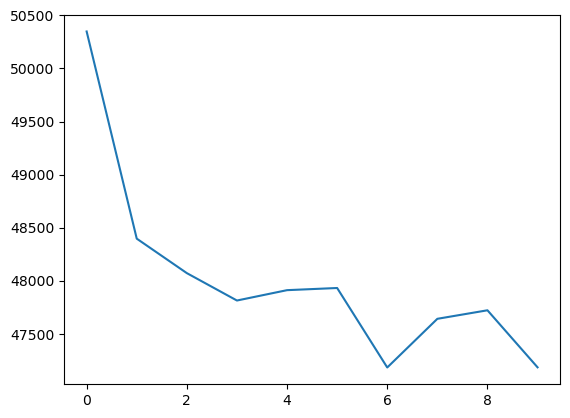

In [47]:
import matplotlib.pyplot as plt

plt.plot(model_history.history["mae"])

Finer optimization near the minimum

In [48]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

test_predictions=model.predict(x_test)
train_predictions=model.predict(x_train)

test_mae=mean_absolute_error(y_test, test_predictions)
train_mae=mean_absolute_error(y_train, train_predictions)

print("test error: ", test_mae)
print("train error: ", train_mae)

print("test error %: ", 100*test_mae/drop_na_data.median_house_value.mean())

print(round(r2_score(y_test, test_predictions),2))

511/511 [==============================] - 1s 1ms/step
test error:  46891.680108559696
train error:  46379.37896278761
test error %:  22.667833192450296
0.69
